<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-new-score" data-toc-modified-id="Create-new-score-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create new score</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Scatter-plot" data-toc-modified-id="Scatter-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scatter plot</a></span></li><li><span><a href="#Details-on-each-problematic-classifications" data-toc-modified-id="Details-on-each-problematic-classifications-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Details on each problematic classifications</a></span><ul class="toc-item"><li><span><a href="#Ambiguous-classification" data-toc-modified-id="Ambiguous-classification-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Ambiguous classification</a></span></li><li><span><a href="#'Some'-category" data-toc-modified-id="'Some'-category-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>'Some' category</a></span></li><li><span><a href="#insufficient-evidence" data-toc-modified-id="insufficient-evidence-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>insufficient evidence</a></span></li><li><span><a href="#Wrongly-classified-jobs" data-toc-modified-id="Wrongly-classified-jobs-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Wrongly classified jobs</a></span><ul class="toc-item"><li><span><a href="#Description-of-the-wrongly-classify-as-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-Software-job-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Description of the wrongly classify as Software job</a></span></li><li><span><a href="#Description-of-the-wrongly-classify-as-NOT-Software-job" data-toc-modified-id="Description-of-the-wrongly-classify-as-NOT-Software-job-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Description of the wrongly classify as NOT Software job</a></span></li></ul></li><li><span><a href="#Strongly-classified-as-Software-job-while-being-'Some'" data-toc-modified-id="Strongly-classified-as-Software-job-while-being-'Some'-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Strongly classified as Software job while being 'Some'</a></span></li></ul></li></ul></div>

In [1]:
import re
import glob
import itertools
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

from include import features

In [2]:
df = pd.read_csv('data/model_data_test.csv')
df = df.drop('Unnamed: 0', axis=1)
len(df)

1217

In [3]:
df['subject_area'].unique()

array(["['Health and Medical']", "['Administrative', 'Student Services']",
       "['Physical and Environmental Sciences', 'Engineering and Technology']",
       "['IT']", "['Computer Science', 'Creative Arts and Design']",
       "['Property and Maintenance']",
       "['Library Services and Information Management', 'Property and Maintenance']",
       "['Health and Medical', 'Mathematics and Statistics']",
       "['Psychology', 'Social Sciences and Social Care']",
       "['Social Sciences and Social Care', 'Business and Management Studies']",
       "['Administrative', 'PR, Marketing, Sales and Communication', 'Student Services']",
       "['Health and Medical', 'Sport and Leisure']",
       "['Health and Medical', 'Biological Sciences']",
       "['Business and Management Studies']",
       "['Health and Medical', 'Biological Sciences', 'Engineering and Technology']",
       "['Historical and Philosophical Studies', 'Senior Management']",
       "['Biological Sciences']",
       "

In [4]:
# Splitting the lists into separated columns

# tags
tags = df['tags'].str.replace("'", "").str.replace(']', '').str.replace('[', '').str.replace(' ', '').str.split(',', expand=True)
tags.columns = ['tags_{}'.format(str(int(x)+1)) for x in tags.columns]
df.drop('tags', axis=1, inplace=True)
# subject area
subjects = df['subject_area'].str.replace("'", "").str.replace(']', '').str.replace('[', '').str.replace(' ', '').str.split(',', expand=True)
subjects.columns = ['subject_{}'.format(str(int(x)+1)) for x in subjects.columns]

# The prediction are in the way to predict if the job is a NOT software job. Inverse the score to make it easier to read
df['prediction_proba'] = df['prediction_proba'].apply(lambda x: 1-x)

df = pd.concat([df, tags, subjects], axis=1, sort=False)


## Create new score

In [5]:
def calculate_score(row):
    """
    This function aggregate the different tags given by people to a job ads into an integrate one, computed with the
    mean and some other calculation to reflect the different possibilities given.
    The different possibilities were:
        1. Insufficient evidence: no enough information to see if the jobs ads requires software development or not
        2. None: no software development required
        3. Some: some software development required
        4. Most: mainly software development
    For the rest it transform the different category into numerical value
        . None: 0
        . Some: 1
        . Most: 2
    From there, the mean is calculated. and from the result the three category are recreated
        . [0, 0.33, 0.5]: None
        . [0.6, 1]: Some
        . > 1: Most
    If there is one insufficient information among the tags, it negative the mean. If there is a consensus of Insufficient
    Information it gives a -10
    
    :params:
        df: containing the columns to compute
    :return:
        a panda Series with the computated mean
    """
    list_values = list()
    insufficient = 0
    for r in row:
        if r == 'No':
            list_values.append(0)
        elif r == 'Some':
            list_values.append(1)
        elif r == 'Most':
            list_values.append(2)
        elif r == 'InsufficientEvidence':
            insufficient +=1
        else:
            pass
    if insufficient > 1:
        return -10
    elif insufficient == 1:
        if len(list_values) == 1:
            return -0
        elif len(list_values) == 0:
            return -10
        else:
            return (-(sum(list_values) / float(len(list_values))))/2
    else:
        if len(list_values) == 1:
            return 0
        else:
            return (sum(list_values) / float(len(list_values)))/2

In [6]:
df['agg_tag'] = df.loc[:, ['tags_1', 'tags_2', 'tags_3']].apply(calculate_score, axis=1)
df['agg_tag'].value_counts()

 0.000000     690
 0.166667      91
 1.000000      84
 0.750000      83
 0.500000      77
-10.000000     45
-0.250000      44
 0.333333      42
-0.500000      29
 0.250000      11
-0.750000      10
 0.666667       6
-1.000000       5
Name: agg_tag, dtype: int64

In [7]:
df['created_tag'] = df['agg_tag'].apply(lambda x: 1 if abs(x)>=.5 and abs(x) < 10 else 0)
df['corresponding_tag'] = np.where(df['created_tag'] == df['prediction'], True, False)

In [8]:
#training[['run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

## Confusion matrix

In [9]:
df.groupby('prediction')['corresponding_tag'].value_counts()

prediction  corresponding_tag
0           True                 830
            False                 27
1           True                 267
            False                 93
Name: corresponding_tag, dtype: int64

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [11]:
y_test = df['created_tag']
y_pred = df['prediction']

In [12]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['Not Research Software Job', 'Research Software Job']

Confusion matrix, without normalization
[[830  93]
 [ 27 267]]


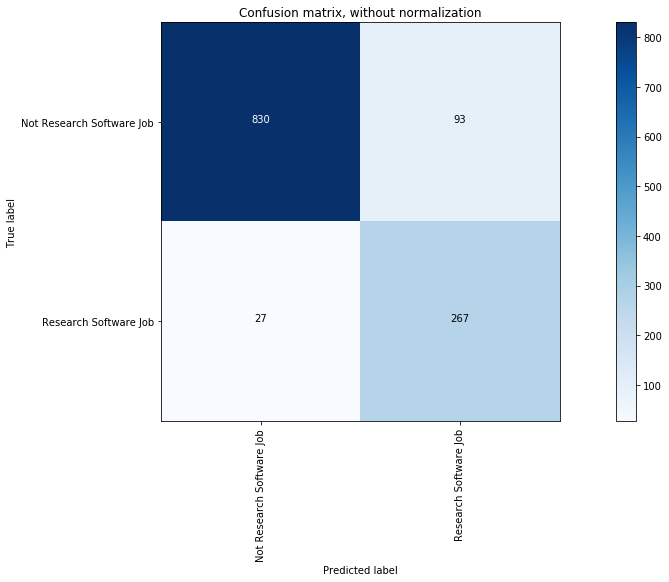

Normalized confusion matrix
[[0.9  0.1 ]
 [0.09 0.91]]


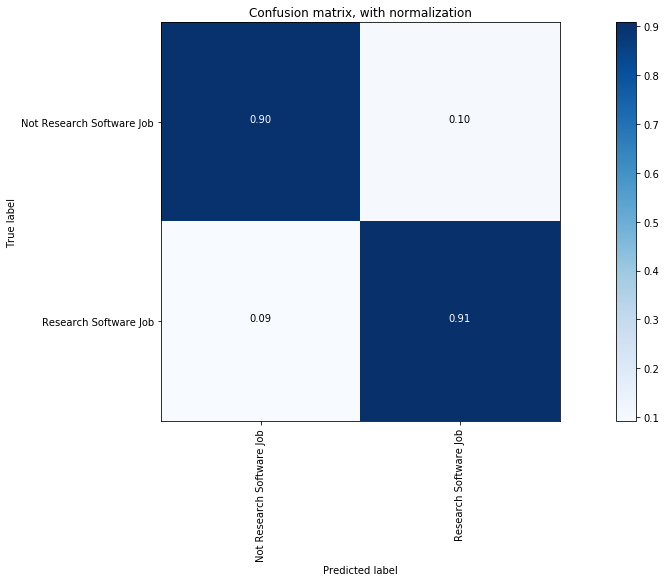

In [13]:
plt.figure(figsize=(16, 8))
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization', normalize=False)
plt.show();

plt.figure(figsize=(16, 8))
plot = plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, with normalization', normalize=True)
plt.show();
#plt.savefig('../outputs/dataPrediction/confusion_matrix_normalised.png', dpi=300, bbox_inches='tight')

## Scatter plot

In [14]:
def color_right(x, y):
    col = list()
    for i, j in zip(x, y):
        if i < 0.5 and j < 0.5:
            col.append('g')
        elif i > 0.5 and j > 0.5:
            col.append('g')
        elif i < 0.5 and j > 0.5:
            col.append('r')
        elif i > 0.5 and j < 0.5:
            col.append('r')
        else:
            col.append('grey')
    return col

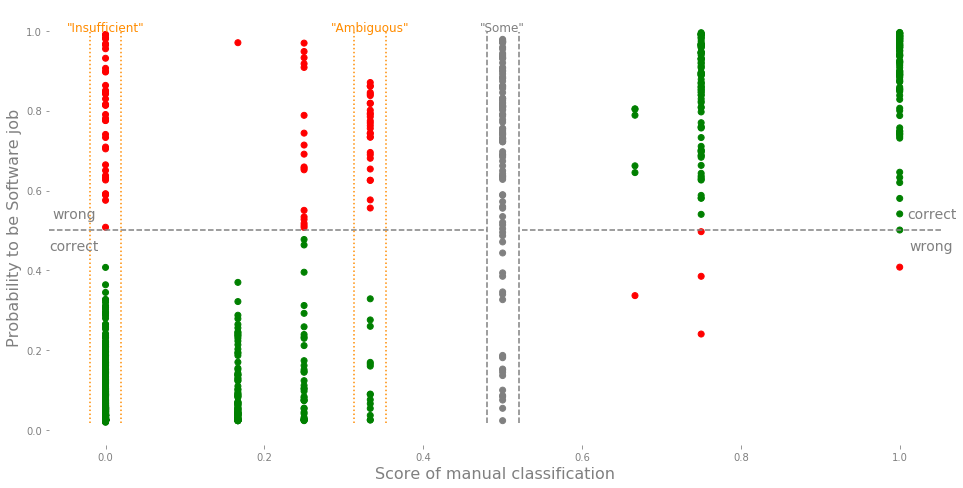

In [60]:
# Get a scatter plot to see the relation between the agg_tag score and the prediction proba to see where the model failed
# It seems to performing relatively according to expectation. There is a confusing point when aggregate score == 1
# and when the aggregate score is between 0.5 and 0.75 where it appears to classify it as in the opposite direction
# These score seems to represent ambiguious score where people have opposite views on the jobs ads. 

tag_creat = [abs(x) for x in df['agg_tag'] if abs(x) < 10]
pred_inv = [x for x in  df[df['agg_tag'] > -10]['prediction_proba']]

col = color_right(tag_creat, pred_inv)

fig, ax = plt.subplots(figsize=(16, 8))

plt.axhline(y=0.5, xmax=0.49, color='grey', linestyle='--')
plt.axvline(x=0.48, ymin=0.05, ymax=0.95, color='grey', linestyle='--')

plt.axhline(y=0.5, xmin=0.53, color='grey', linestyle='--')
plt.axvline(x=0.52,ymin=0.05, ymax=0.95, color='grey', linestyle='--')

plt.axvline(x=0.31333, ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.axvline(x=0.35333,ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.text(0.3333,1,'"Ambiguous"', color='darkorange', fontsize=12, horizontalalignment='center')

plt.axvline(x=0.02, ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.axvline(x=-0.02,ymin=0.05, ymax=0.95, color='darkorange', linestyle=':')
plt.text(0.0,1,'"Insufficient"', color='darkorange', fontsize=12, horizontalalignment='center')


plt.text(0.5,1,'"Some"', color='grey', fontsize=12, horizontalalignment='center')

plt.text(1.04,0.53,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(-0.04,0.45,'correct', color='grey',fontsize=14, horizontalalignment='center')
plt.text(1.04,0.45,'wrong', color='grey', fontsize=14, horizontalalignment='center')
plt.text(-0.04,0.53,'wrong', color='grey', fontsize=14, horizontalalignment='center')

ax.set_ylabel('Probability to be Software job', fontsize=16, color='grey')
ax.tick_params(axis='y', colors='grey')

ax.set_xlabel('Score of manual classification', fontsize=16, color='grey')
ax.tick_params(axis='x', colors='grey')

plt.scatter(tag_creat, pred_inv, color=col)

for d in ["left", "top", "bottom", "right"]:
    plt.gca().spines[d].set_visible(False)


## Details on each problematic classifications

 ### Ambiguous classification

In [16]:
df[(df['agg_tag'] > 0.3) & (df['agg_tag'] < 0.4)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
11,AJB093,first_run,No,Most,No,0.333333,0,0,0.076061,True
15,AJB524,first_run,No,No,Most,0.333333,0,0,0.089085,True
24,AJC363,first_run,Some,No,Some,0.333333,0,1,0.801198,False
67,AJJ269,first_run,No,No,Most,0.333333,0,0,0.025219,True
69,AJJ541,first_run,Some,Some,No,0.333333,0,1,0.774545,False
71,AJJ630,first_run,Some,No,Some,0.333333,0,1,0.784730,False
118,AJR085,first_run,Some,No,Some,0.333333,0,1,0.841471,False
121,AJR391,first_run,Some,No,Some,0.333333,0,1,0.625704,False
162,AJZ805,first_run,Some,Some,No,0.333333,0,1,0.733993,False
171,AKA464,first_run,Some,No,Some,0.333333,0,1,0.742850,False


### 'Some' category

In [17]:
df[(abs(df['agg_tag']) ==0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
3,AIZ429,first_run,Some,Some,None,0.5,1,1,0.930705,True
20,AJB834,first_run,No,InsufficientEvidence,Most,-0.5,1,0,0.495131,False
33,AJE034,first_run,Some,Some,None,0.5,1,1,0.932115,True
38,AJE987,first_run,No,InsufficientEvidence,Most,-0.5,1,0,0.150855,False
39,AJF111,first_run,Some,Some,None,0.5,1,1,0.931772,True
44,AJF652,first_run,Some,Some,None,0.5,1,1,0.588299,True
48,AJH016,first_run,No,Most,InsufficientEvidence,-0.5,1,0,0.393727,False
59,AJI375,first_run,Some,Some,None,0.5,1,1,0.751355,True
62,AJI549,first_run,Some,Some,None,0.5,1,1,0.820808,True
65,AJJ046,first_run,InsufficientEvidence,Some,Some,-0.5,1,1,0.803341,True


### insufficient evidence

In [18]:
df[(df['agg_tag'] <0)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
20,AJB834,first_run,No,InsufficientEvidence,Most,-0.50,1,0,0.495131,False
35,AJE394,first_run,InsufficientEvidence,InsufficientEvidence,No,-10.00,0,0,0.066633,True
38,AJE987,first_run,No,InsufficientEvidence,Most,-0.50,1,0,0.150855,False
47,AJG800,first_run,InsufficientEvidence,InsufficientEvidence,None,-10.00,0,0,0.190167,True
48,AJH016,first_run,No,Most,InsufficientEvidence,-0.50,1,0,0.393727,False
63,AJI676,first_run,Some,InsufficientEvidence,No,-0.25,0,0,0.173794,True
64,AJI975,first_run,Most,InsufficientEvidence,InsufficientEvidence,-10.00,0,0,0.049979,True
65,AJJ046,first_run,InsufficientEvidence,Some,Some,-0.50,1,1,0.803341,True
78,AJK859,first_run,InsufficientEvidence,Some,No,-0.25,0,0,0.292337,True
80,AJL914,first_run,Most,InsufficientEvidence,Most,-1.00,1,0,0.408043,False


### Wrongly classified jobs

#### Description of the wrongly classify as Software job

In [19]:
df[(abs(df['agg_tag']) < 0.33) &(df['prediction_proba'] > 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
105,AJO760,first_run,Some,No,InsufficientEvidence,-0.250000,0,1,0.655639,False
179,AKB794,first_run,No,Some,InsufficientEvidence,-0.250000,0,1,0.534018,False
397,ALN210,first_run,Some,InsufficientEvidence,No,-0.250000,0,1,0.743739,False
420,ALR295,first_run,Some,No,InsufficientEvidence,-0.250000,0,1,0.917666,False
426,ALS409,first_run,Some,InsufficientEvidence,No,-0.250000,0,1,0.908283,False
432,ALT703,first_run,No,InsufficientEvidence,Some,-0.250000,0,1,0.507458,False
493,AMF348,first_run,InsufficientEvidence,Some,No,-0.250000,0,1,0.659003,False
568,AMQ686,first_run,InsufficientEvidence,No,Some,-0.250000,0,1,0.527544,False
582,AMT536,first_run,InsufficientEvidence,No,Some,-0.250000,0,1,0.948265,False
652,AND726,first_run,No,No,None,0.000000,0,1,0.863378,False


In [20]:
wrong_soft = df[(abs(df['agg_tag']) < 0.33) &(df['prediction_proba'] > 0.5)]['description']
for i, txt in enumerate(wrong_soft):
    i+=1
    print('\n')
    print('Jobs: {}'.format(i))
    print(txt)



Jobs: 1

 Applications are invited for a Research Associate to work with Professor Ajit Lalvani in the Tuberculosis Research Centre.  The Tuberculosis Research Centre (within the Respiratory Infections Section, National Heart & Lung Institute) is based at the St Mary’s Campus, Paddington, and is a world class multi-disciplinary team of scientists, clinicians and research nurses investigating basic science, translational and clinical aspects of TB. 
 You will, under the direction of Professor Lalvani, use recently-developed new immunological techniques to define and validate novel biomarkers of TB infection and disease. The technologies that will be evaluated and further developed include (but are not limited to): flow cytometry, ELISA, ELISpot, fluorescence linked immunospot, and multi cytokine bead array.  These assays will be applied to a unique prospectively collected bio bank of clinical samples from over 1000 TB patients.  You will conduct your own analyses of the data generated

#### Description of the wrongly classify as NOT Software job

In [21]:
df[(abs(df['agg_tag']) > 0.5) & (abs(df['agg_tag']) < 10) &(df['prediction_proba'] < 0.5)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
58,AJH869,first_run,Most,Most,No,0.666667,1,0,0.336756,False
80,AJL914,first_run,Most,InsufficientEvidence,Most,-1.000000,1,0,0.408043,False
319,ALA126,first_run,Some,Most,None,0.750000,1,0,0.385134,False
471,AMB006,first_run,Some,Most,None,0.750000,1,0,0.496890,False
700,ANM607,first_run,Some,Most,None,0.750000,1,0,0.240489,False


In [22]:
wrong_not = df[(abs(df['agg_tag']) > 0.5) & (abs(df['agg_tag']) < 10) &(df['prediction_proba'] < 0.5)]['description']
for i, txt in enumerate(wrong_not):
    i+=1
    print('\n')
    print('Jobs: {}'.format(i))
    print(txt)



Jobs: 1

 The Faculty of Engineering and Environment is passionate about the principles and applications of Science and Technology in all its forms and strives to be excellent in research, teaching and innovation. 
 We seek to appoint a high calibre individual with an excellent international reputation to the Department of Computer Science and Digital Technologies. You will drive and enhance the best quality research, teaching and entrepreneurial activities and actively encourage this amongst colleagues. The department has particular strengths in computer networks, ethical hacking, and computer forensics. Candidates with expertise in these or any relevant areas of research, particularly AI, computer games, animation and visual effects, web / image processing are welcome to apply. Candidates with expertise in these or any relevant area of research are welcome to apply. The department will consider high quality applicants in any area of research. 
 You must hold a first degree and be q

### Strongly classified as Software job while being 'Some'

In [23]:
df[(abs(df['agg_tag']) == 0.5) & (df['prediction_proba'] > 0.9)][['jobid', 'run_tag', 'tags_1', 'tags_2', 'tags_3', 'agg_tag', 'created_tag', 'prediction', 'prediction_proba', 'corresponding_tag']]

,jobid,run_tag,tags_1,tags_2,tags_3,agg_tag,created_tag,prediction,prediction_proba,corresponding_tag
3,AIZ429,first_run,Some,Some,None,0.5,1,1,0.930705,True
33,AJE034,first_run,Some,Some,None,0.5,1,1,0.932115,True
39,AJF111,first_run,Some,Some,None,0.5,1,1,0.931772,True
66,AJJ266,first_run,Most,No,Some,0.5,1,1,0.970134,True
218,AKJ535,first_run,Some,Some,None,0.5,1,1,0.906515,True
266,AKQ443,first_run,Most,No,Some,0.5,1,1,0.919810,True
295,AKV139,first_run,Some,Some,None,0.5,1,1,0.900863,True
314,AKY775,first_run,No,Most,Some,0.5,1,1,0.959050,True
427,ALS850,first_run,Some,No,Most,0.5,1,1,0.973076,True
528,AMK742,first_run,InsufficientEvidence,Some,Some,-0.5,1,1,0.935591,True


In [24]:
wrong_some = df[(abs(df['agg_tag']) == 0.5) & (df['prediction_proba'] > 0.9)]['description']
for i, txt in enumerate(wrong_some):
    i+=1
    print('\n')
    print('Jobs: {}'.format(i))
    print(txt)



Jobs: 1

 Andrew Wiles Building, Radcliffe Observatory Quarter, Woodstock Road, Oxford 
 Do you consider yourself a capable systems administrator? Are you professional, diligent, methodical and a skilled trouble-shooter? Are you passionate about and take a pride in the work that you do? 
 Then this may be your opportunity to join a dynamic, friendly, well established team responsible for providing IT support within the Mathematical Institute at the University of Oxford. 
 Reporting to the Head of IT, your primary responsibilities will include front line desktop user support as well as assisting in maintaining departmental IT systems and in particular being involved in several of the upcoming system development projects. As part of an IT team of 7 you will work individually as well as collaborating with other team members. The IT team collectively support system security, upgrades and development, as well as providing general IT support in person and via an email trouble ticketing sys

In [25]:
df['run_tag'].unique()

array(['first_run', 'second_run', 'third_run'], dtype=object)

In [26]:
df.to_csv('./data/training_set/training_set.csv')